## Deep Learningv Project (MNIST)

### Loading dataset (MNIST)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset, ConcatDataset
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
# For reproducibility 
torch.manual_seed(0)
np.random.seed(0)

In [4]:
# Load MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

X = train_dataset.data.numpy()
y = train_dataset.targets.numpy()

print("Original dataset:", X.shape, y.shape)

Original dataset: (60000, 28, 28) (60000,)


In [5]:
# Semi-supervised split (10 labeled / class)
labels_per_class = 10
labeled_idx = []
unlabeled_idx = []

for c in range(10):
    class_idx = np.where(y == c)[0]
    np.random.shuffle(class_idx)
    labeled_idx.extend(class_idx[:labels_per_class])
    unlabeled_idx.extend(class_idx[labels_per_class:])

labeled_idx = np.array(labeled_idx)
unlabeled_idx = np.array(unlabeled_idx)

X_labeled = X[labeled_idx]
y_labeled = y[labeled_idx]
X_unlabeled = X[unlabeled_idx]

print("Labeled samples:", len(X_labeled))
print("Unlabeled samples:", len(X_unlabeled))

Labeled samples: 100
Unlabeled samples: 59900


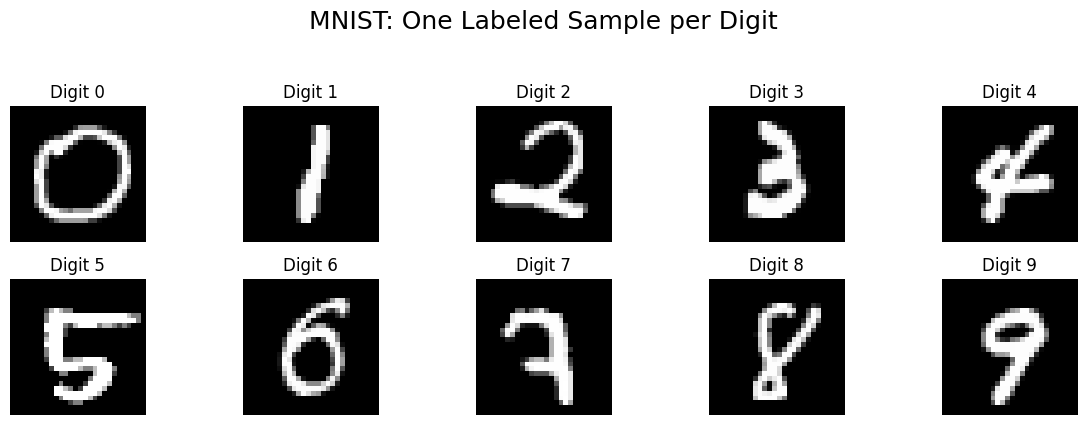

In [6]:
# EDA - One Sample per Digit
plt.figure(figsize=(12, 4))
for digit in range(10):
    idx = np.where(y_labeled == digit)[0][0]
    plt.subplot(2, 5, digit + 1)
    plt.imshow(X_labeled[idx], cmap="gray")
    plt.title(f"Digit {digit}", fontsize=12)
    plt.axis("off")

plt.suptitle("MNIST: One Labeled Sample per Digit", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()

In [7]:
# Test Set
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [8]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 28 -> 14
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 14 -> 7
            nn.LeakyReLU(0.2)
        )
        self.fc = nn.Linear(64 * 7 * 7, 128)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x   # (batch, 128)


class ClassifierHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.fc = nn.Linear(128, num_classes)

    def forward(self, h):
        return self.fc(h)


class BaselineClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = FeatureExtractor()
        self.classifier = ClassifierHead(10)

    def forward(self, x):
        h = self.features(x)
        logits = self.classifier(h)
        return logits

In [9]:
def train_and_test_baseline(model, train_loader, test_loader, epochs=50, lr=1e-3, device="cpu"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    acc = correct / total
    return acc


In [10]:
# Baseline training 
train_loader_100 = DataLoader(
    Subset(train_dataset, labeled_idx),
    batch_size=16,
    shuffle=True
)

baseline_model = BaselineClassifier()
baseline_acc = train_and_test_baseline(
    baseline_model, train_loader_100, test_loader, epochs=20, device = device
)

print(f"\nBaseline model (trained on all 100 labels) accuracy: {baseline_acc*100:.2f}%")

# BASELINE CURVES (10 → 100 LABELED, 3 RUNS)
sizes = list(range(10, 101, 10))  # [10,20,...,100]
runs = 3
baseline_results = {r: [] for r in range(runs)}

for size in sizes:
    print(f"\n=== Training with {size} labeled samples ===")
    for r in range(runs):
        idx = np.random.choice(len(X_labeled), size, replace=False)

        subset_idx = labeled_idx[idx]
        train_loader = DataLoader(
            Subset(train_dataset, subset_idx),
            batch_size=16,
            shuffle=True
        )

        model = BaselineClassifier()
        acc = train_and_test_baseline(model, train_loader, test_loader, epochs=50, device = device)
        baseline_results[r].append(acc)
        print(f"Run {r+1}: accuracy = {acc*100:.2f}%")



Baseline model (trained on all 100 labels) accuracy: 75.63%

=== Training with 10 labeled samples ===
Run 1: accuracy = 32.15%
Run 2: accuracy = 30.90%
Run 3: accuracy = 26.37%

=== Training with 20 labeled samples ===
Run 1: accuracy = 50.77%
Run 2: accuracy = 51.64%
Run 3: accuracy = 39.90%

=== Training with 30 labeled samples ===
Run 1: accuracy = 59.83%
Run 2: accuracy = 61.75%
Run 3: accuracy = 58.26%

=== Training with 40 labeled samples ===
Run 1: accuracy = 66.21%
Run 2: accuracy = 63.04%
Run 3: accuracy = 64.97%

=== Training with 50 labeled samples ===
Run 1: accuracy = 67.74%
Run 2: accuracy = 64.47%
Run 3: accuracy = 62.93%

=== Training with 60 labeled samples ===
Run 1: accuracy = 69.45%
Run 2: accuracy = 70.44%
Run 3: accuracy = 70.09%

=== Training with 70 labeled samples ===
Run 1: accuracy = 74.03%
Run 2: accuracy = 73.12%
Run 3: accuracy = 71.89%

=== Training with 80 labeled samples ===
Run 1: accuracy = 74.40%
Run 2: accuracy = 74.80%
Run 3: accuracy = 74.41%

==

### Using Semi-Supervised method with GAN

  > Train discriminator to classify K+1 classes
  
  > Generator creates fake MNIST digits using feature matching

In [11]:
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = FeatureExtractor()
        self.classifier = ClassifierHead(11)  # 10 digits + 1 fake

    def forward(self, x):
        features = self.features(x)
        logits = self.classifier(features)
        return logits, features

In [13]:
def supervised_loss(logits, labels):
    return F.cross_entropy(logits[:, :10], labels)

def unsupervised_loss(logits_real, logits_fake):
    # real data should NOT be fake
    real_loss = -torch.mean(
        torch.log(1 - F.softmax(logits_real, dim=1)[:, -1] + 1e-8)
    )
    # fake data SHOULD be fake
    fake_loss = -torch.mean(
        torch.log(F.softmax(logits_fake, dim=1)[:, -1] + 1e-8)
    )
    return real_loss + fake_loss

def feature_matching_loss(real_features, fake_features):
    return torch.mean((real_features.mean(0) - fake_features.mean(0)) ** 2)

In [14]:
def train_ssl_gan(labeled_loader, unlabeled_loader, epochs=50, z_dim=100, device="cpu"):
    G = Generator().to(device)
    D = Discriminator().to(device)

    opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
    opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

    for epoch in range(epochs):
        unlabeled_iter = iter(unlabeled_loader)

        for x_labeled, y in labeled_loader:
            try:
                x_unlabeled, _ = next(unlabeled_iter)
            except StopIteration:
                unlabeled_iter = iter(unlabeled_loader)
                x_unlabeled, _ = next(unlabeled_iter)

            x_labeled, y = x_labeled.to(device), y.to(device)
            x_unlabeled = x_unlabeled.to(device)

            # Train Discriminator
            z = torch.randn(x_unlabeled.size(0), z_dim).to(device)
            x_fake = G(z)

            logits_lab, _ = D(x_labeled)
            logits_unlab, _ = D(x_unlabeled)
            logits_fake, _ = D(x_fake.detach())

            L_sup = supervised_loss(logits_lab, y)
            L_unsup = unsupervised_loss(logits_unlab, logits_fake)
            L_D = L_sup + L_unsup

            opt_D.zero_grad()
            L_D.backward()
            opt_D.step()

            # Train Generator (feature matching) 
            _, feat_real = D(x_unlabeled)
            _, feat_fake = D(x_fake)

            L_G = feature_matching_loss(feat_real, feat_fake)

            opt_G.zero_grad()
            L_G.backward()
            opt_G.step()

    # Discard generator, return trained discriminator
    return D


In [15]:
def evaluate_ssl(D, test_loader, device="cpu"):
    D.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits, _ = D(x)
            preds = logits[:, :10].argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total

In [16]:
def run_ssl_experiment(labeled_idx, unlabeled_idx, test_loader, label_sizes, runs=10, epochs=50, device="cpu"):
    results = {L: [] for L in label_sizes}

    for L in label_sizes:
        for run in range(runs):
            idx = np.random.choice(labeled_idx, L, replace=False)

            labeled_loader = DataLoader(
                Subset(train_dataset, idx),
                batch_size=16,
                shuffle=True
            )

            unlabeled_loader = DataLoader(
                Subset(train_dataset, unlabeled_idx),
                batch_size=64,
                shuffle=True
            )

            D = train_ssl_gan(
                labeled_loader,
                unlabeled_loader,
                epochs=epochs,
                device=device
            )

            acc = evaluate_ssl(D, test_loader, device)
            results[L].append(acc)

            print(f"L={L}, run={run}, acc={acc:.4f}")

    return results


In [17]:
label_sizes = list(range(10, 101, 10))  
runs = 3
epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

ssl_results = run_ssl_experiment(
    labeled_idx=labeled_idx,
    unlabeled_idx=unlabeled_idx,
    test_loader=test_loader,
    label_sizes=label_sizes,
    runs=runs,
    epochs=epochs,
    device=device
)

L=10, run=0, acc=0.3116
L=10, run=1, acc=0.2813
L=10, run=2, acc=0.2055
L=20, run=0, acc=0.4837
L=20, run=1, acc=0.4823
L=20, run=2, acc=0.4585
L=30, run=0, acc=0.4937
L=30, run=1, acc=0.5799
L=30, run=2, acc=0.5707
L=40, run=0, acc=0.6766
L=40, run=1, acc=0.6412
L=40, run=2, acc=0.6776
L=50, run=0, acc=0.7220
L=50, run=1, acc=0.6468
L=50, run=2, acc=0.6619
L=60, run=0, acc=0.6984
L=60, run=1, acc=0.7679
L=60, run=2, acc=0.6757
L=70, run=0, acc=0.7422
L=70, run=1, acc=0.7342
L=70, run=2, acc=0.7275
L=80, run=0, acc=0.7551
L=80, run=1, acc=0.7400
L=80, run=2, acc=0.7638
L=90, run=0, acc=0.7611
L=90, run=1, acc=0.7626
L=90, run=2, acc=0.7579
L=100, run=0, acc=0.7938
L=100, run=1, acc=0.7770
L=100, run=2, acc=0.7748


In [18]:
ssl_mean = []
ssl_std = []

for L in label_sizes:
    ssl_mean.append(np.mean(ssl_results[L]))
    ssl_std.append(np.std(ssl_results[L]))

    
baseline_mean = []
baseline_std = []

for i, L in enumerate(label_sizes):
    accs = [baseline_results[r][i] for r in range(runs)]
    baseline_mean.append(np.mean(accs))
    baseline_std.append(np.std(accs))

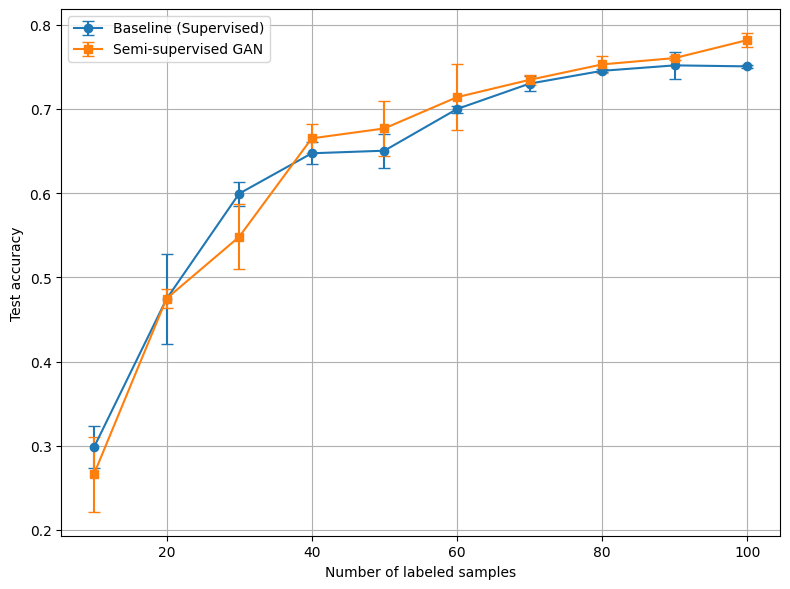

In [ ]:
plt.figure(figsize=(8, 6))

plt.errorbar(
    label_sizes,
    baseline_mean,
    yerr=baseline_std,
    label="Baseline (Supervised)",
    marker="o",
    capsize=4
)

plt.errorbar(
    label_sizes,
    ssl_mean,
    yerr=ssl_std,
    label="Semi-supervised GAN",
    marker="s",
    capsize=4
)

plt.xlabel("Number of labeled samples")
plt.ylabel("Test accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
